In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
def get_nfts(num_nfts):
  return np.linspace(1, num_nfts, num_nfts)

# Given number of nfts and price, returns the buy/sell price at each instantaneous point
# Returns instantaneous price, buy price, sell price (per row), slippage
def constant_product(num_nfts, nft_price):
  x = num_nfts
  y = num_nfts*nft_price
  k = x*y
  xs = get_nfts(num_nfts*2)
  ys = np.zeros(len(xs))
  prices = np.zeros((len(xs), 4))
  for index, x_value in enumerate(xs):
    y_value = k/x_value
    ys[index] = y_value
  for index, y_value in enumerate(ys):
    buy_price = 0
    sell_price = 0
    if index > 0:
      buy_price = ys[index-1]-ys[index]
    if index < len(ys)-1:
      sell_price = ys[index]-ys[index+1]
    instant_price = y_value/(index+1)
    prices[index] = [instant_price, buy_price, sell_price, (buy_price-sell_price)/instant_price]
  return prices

# Given a list of prices (like the kind `constant_product` above returns)
# a starting price, and a multiplier, will return the prices that fall into this range
def liquidity_depth(prices, spot_price, multiplier):
  min_price = spot_price/multiplier
  max_price = spot_price*multiplier
  start_index = -1
  end_index = -1
  for index, p in enumerate(prices):
    buy_price = p[1]
    sell_price = p[2]
    if start_index == -1:
      if (buy_price != 0 and buy_price < max_price) or sell_price < max_price:
        start_index = index
    if end_index == -1:
      if (buy_price != 0 and buy_price < min_price) or sell_price < min_price:
        end_index = index
  if end_index == -1:
    end_index = len(prices)
  if start_index == -1:
    start_index = 0
  return min_price, max_price, prices[start_index:end_index+1,:]

# Given a list of prices, a starting price, and the number of nfts to buy/sell,
# will return the average price to buy/sell that number of nfts
def avg_price(prices, spot_price, num_nfts_to_transact, is_buy):
  middle_index = int(len(prices)/2)-1
#   assert(prices[middle_index][0] == spot_price)
  if is_buy:
    total = np.sum(prices[middle_index-num_nfts_to_transact+1:middle_index+1, 1])
  else:
    total = np.sum(prices[middle_index:middle_index+num_nfts_to_transact, 2])
  return total/num_nfts_to_transact

In [3]:
num_nfts = 10
spot_price = 1
depth_multiplier = 1.5

prices = constant_product(num_nfts, spot_price)
avg_price(prices, spot_price, 1, True)

1.3888888888888893

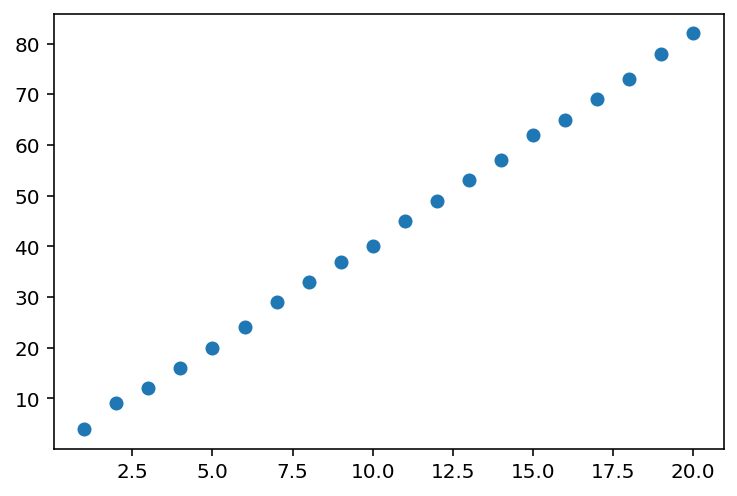

In [4]:
# Liquidity around a price (+/-) X% scales linearly with the amount of liquidity 
# placed into the pool for constant product
range_lengths = []
for i in range(1, 21):
  num_nfts = i*10
  prices = constant_product(num_nfts, spot_price)
  min_price, max_price, price_range = liquidity_depth(prices, spot_price, depth_multiplier)
  range_lengths.append(len(price_range))
plt.scatter(get_nfts(20), range_lengths)
plt.show()

In [29]:
# Given number of nfts, price, delta
# Returns instantaneous price, buy price, sell price (per row), slippage
def linear_curve(num_nfts, nft_price, delta):
    prices = np.zeros((num_nfts*2, 4))
    for i in range(-num_nfts, num_nfts):
      buy_price = nft_price + (i+1)*delta
      sell_price = nft_price + (i)*delta
      # insert in sequential order 
      prices[-(i+num_nfts)-1] = [num_nfts-i,
                                 buy_price, sell_price, (buy_price-sell_price)/(buy_price+sell_price)]
    return prices

# Given number of nfts, price, delta
# Returns instantaneous price, buy price, sell price (per row), slippage
def exponential_curve(num_nfts, nft_price, delta):
    assert(delta > 1)
    prices = np.zeros((num_nfts*2, 4))
    for i in range(-num_nfts, num_nfts):
      buy_price = nft_price * np.power([delta], i)
      sell_price = nft_price * np.power([delta], i-1)
      # insert in sequential order 
      prices[-(i+num_nfts)-1] = [num_nfts-i,
                                 buy_price, sell_price, (buy_price-sell_price)/(buy_price+sell_price)]
    return prices

In [71]:
num_nfts = 10
prices = [constant_product(num_nfts, spot_price),
         linear_curve(num_nfts, spot_price, spot_price/num_nfts),
         exponential_curve(num_nfts, spot_price, 1+1/(num_nfts))]

range_multipliers = [1.25, 1.5, 1.75, 2.0, 3.0, 4.0]

coverage = np.zeros((len(prices), len(range_multipliers)))

for x, m in enumerate(range_multipliers):
  for y, p in enumerate(prices):
    p1, p2, ranges = liquidity_depth(p, spot_price, m)
    coverage[y, x] = len(ranges)/len(p)

In [72]:
coverage

array([[0.15, 0.25, 0.3 , 0.4 , 0.6 , 0.8 ],
       [0.3 , 0.45, 0.65, 0.8 , 0.85, 0.9 ],
       [0.3 , 0.5 , 0.6 , 0.8 , 1.  , 1.  ]])

In [32]:
prices[2]

array([[ 1.        ,  2.35794769,  2.14358881,  0.04761905],
       [ 2.        ,  2.14358881,  1.9487171 ,  0.04761905],
       [ 3.        ,  1.9487171 ,  1.771561  ,  0.04761905],
       [ 4.        ,  1.771561  ,  1.61051   ,  0.04761905],
       [ 5.        ,  1.61051   ,  1.4641    ,  0.04761905],
       [ 6.        ,  1.4641    ,  1.331     ,  0.04761905],
       [ 7.        ,  1.331     ,  1.21      ,  0.04761905],
       [ 8.        ,  1.21      ,  1.1       ,  0.04761905],
       [ 9.        ,  1.1       ,  1.        ,  0.04761905],
       [10.        ,  1.        ,  0.90909091,  0.04761905],
       [11.        ,  0.90909091,  0.82644628,  0.04761905],
       [12.        ,  0.82644628,  0.7513148 ,  0.04761905],
       [13.        ,  0.7513148 ,  0.68301346,  0.04761905],
       [14.        ,  0.68301346,  0.62092132,  0.04761905],
       [15.        ,  0.62092132,  0.56447393,  0.04761905],
       [16.        ,  0.56447393,  0.51315812,  0.04761905],
       [17.        ,  0.

In [73]:
prices[2][:, 3] = prices[2][:, 3]*100 
table = pd.DataFrame(prices[2][:, 1:],
             index=[str(i) + " NFTs in Pool" for i in range(1, num_nfts*2+1)],
             columns=["ETH Price to Buy 1 NFT", "ETH Price to Sell 1 NFT", "Slippage % between Buy/Sell"]
            )
table = table.round(3)

In [37]:
buy_prices = []
sell_prices = []

for i in range(1, 6):
  buy_prices.append(avg_price(prices[2], spot_price, i, True))
  sell_prices.append(avg_price(prices[2], spot_price, i, False))

In [74]:
table = pd.DataFrame(np.array([buy_prices, sell_prices]),
             columns=["For 1 NFT", "For 2 NFTs", "For 3 NFTs", "For 4 NFTs", "For 5 NFTs"],
             index=["Avg Buying Price", "Avg Selling Price"])
table = table.round(3)

In [47]:
multipliers = [1.25, 1.5, 1.75, 2, 3, 4]
ranges = []
for m in multipliers:
  p1, p2, price = liquidity_depth(prices[2], spot_price, m)
  ranges.append(len(price)/len(prices[2]))

In [61]:
liquidity_depth(prices[2], spot_price, 3)

(0.3333333333333333,
 3,
 array([[ 1.        ,  2.35794769,  2.14358881,  0.04761905],
        [ 2.        ,  2.14358881,  1.9487171 ,  0.04761905],
        [ 3.        ,  1.9487171 ,  1.771561  ,  0.04761905],
        [ 4.        ,  1.771561  ,  1.61051   ,  0.04761905],
        [ 5.        ,  1.61051   ,  1.4641    ,  0.04761905],
        [ 6.        ,  1.4641    ,  1.331     ,  0.04761905],
        [ 7.        ,  1.331     ,  1.21      ,  0.04761905],
        [ 8.        ,  1.21      ,  1.1       ,  0.04761905],
        [ 9.        ,  1.1       ,  1.        ,  0.04761905],
        [10.        ,  1.        ,  0.90909091,  0.04761905],
        [11.        ,  0.90909091,  0.82644628,  0.04761905],
        [12.        ,  0.82644628,  0.7513148 ,  0.04761905],
        [13.        ,  0.7513148 ,  0.68301346,  0.04761905],
        [14.        ,  0.68301346,  0.62092132,  0.04761905],
        [15.        ,  0.62092132,  0.56447393,  0.04761905],
        [16.        ,  0.56447393,  0.5131581